In [14]:
# autoreload all packages if changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
!poetry install

dyld[35281]: Library not loaded: /opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/Python
  Referenced from: <3F2D0F69-E25A-3340-8B52-46400654C50E> /Users/georg.sorst/Library/Application Support/pypoetry/venv/bin/python
  Reason: tried: '/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/System/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file, not in dyld cache)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from adjustText import adjust_text
import matplotlib.pyplot as plt

In [17]:
def get_torch_device_name() -> str:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.backends.mps.is_available():
        device_name = "mps"
    else:
        device_name = "cpu"
    return device_name

# Word Embeddings

Computers cannot deal with words but they can deal very well with numbers.

Transforming text into vectors will create a vector space where related words are close together.

Special kinds of Neural Networks (_Transformers_) can perform this transformation.

This technique is the basis of LLMs (ChatGPT) and Vector Search.

Let's define some words.

In [18]:
words = [
    "queen",
    "king",
    "prince",
    "princes",
    "man",
    "woman",
    "boy",
    "girl",
    "red",
    "green",
    "blue",
    "palace",
]

In [19]:
pd.DataFrame(words)

,0
0,queen
1,king
2,prince
3,princes
4,man
5,woman
6,boy
7,girl
8,red
9,green


Python makes it very easy to download and use a Transformer model.

In [20]:
def embed(sentences):
    model_name = "all-MiniLM-L6-v2"
    model = SentenceTransformer(
        model_name,
        device=get_torch_device_name(),  # Optional: if you want to run this on GPU
    )
    return model.encode(sentences)

Each word is transformed into a multidimensional vector.

The number of dimensions depends on the used model, in this case it's 384 dimensions.

All vectors have the same number of dimensions.

In [21]:
pd.DataFrame(embed(words[0:5]))

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.035487,-0.065605,-0.009935,0.031590,-0.013387,0.028892,0.116708,-0.034309,0.054405,-0.005583,...,0.023805,0.011133,-0.062244,0.011289,-0.058576,0.026038,0.091385,-0.053889,-0.031242,-0.086961
1,-0.059599,0.050512,-0.069510,0.079680,-0.046748,0.000989,0.079043,-0.012739,0.058396,-0.031402,...,0.087435,0.003265,-0.026208,0.038800,-0.073888,-0.015720,0.164207,-0.030399,-0.001087,-0.015922
2,-0.036829,0.041282,0.041857,0.041772,-0.024362,0.021379,0.099042,0.011144,0.004807,-0.046147,...,0.083732,0.010616,0.028862,0.044962,-0.127518,0.023126,0.126992,-0.046524,-0.012280,0.023921
3,-0.021934,0.012084,-0.004360,-0.004024,-0.026497,-0.014513,0.065083,-0.045122,0.013444,0.000632,...,0.062654,-0.080417,-0.017940,0.030397,-0.082131,-0.008283,0.139276,-0.058748,0.013572,0.011008
4,-0.109676,0.043742,-0.026319,-0.029326,0.021555,-0.085486,0.113728,-0.068247,-0.011020,-0.046630,...,0.103782,-0.041916,-0.006277,-0.001901,-0.015105,-0.026253,0.125931,-0.068597,-0.012884,0.007734


So now we a 384-dimensional vector for each of our words.

In [22]:
pd.DataFrame(
    {
        "Sentence": words[0:5],
        "Encoding": list(embed(words[0:5])),
    }
)

,Sentence,Encoding
0,queen,"[0.03548699, -0.06560461, -0.009934981, 0.0315..."
1,king,"[-0.059599303, 0.05051237, -0.06951009, 0.0796..."
2,prince,"[-0.036828827, 0.041281935, 0.041856598, 0.041..."
3,princes,"[-0.021934113, 0.012083549, -0.004359576, -0.0..."
4,man,"[-0.10967564, 0.043741956, -0.026319038, -0.02..."


# Visualization

The vectors of related texts appear close together in the vector space.

These relations are clearly visible when visualizing the vectors.

We can only plot 2-dimensional vectors, so we must first apply a Principal Component Analysis (PCA) to reduce them to two dimensions.

In [23]:
def flatten_embeddings(embeddings):
    return PCA(n_components=2).fit_transform(embeddings)

The text vectors now only have 2 dimensions each.

Note that PCA reduces the precision of the vectors but allows us to plot them.

In [24]:
flattened_embeddings = flatten_embeddings(embed(words[0:5]))
pd.DataFrame(
    {
        "Sentence": words[0:5],
        "Encoding": list(flattened_embeddings),
    }
)

,Sentence,Encoding
0,queen,"[-0.16153204, 0.44272614]"
1,king,"[-0.0860315, 0.3734935]"
2,prince,"[-0.26614225, -0.29707003]"
3,princes,"[-0.34881434, -0.38995075]"
4,man,"[0.8625197, -0.12919901]"


We can now plot the 2-dimensional vectors to visualize their relationships.

When visualizing the vectors, clear semantic clusters appear.

In [39]:
def plot(sentences, embeddings, color="blue", figure=None):
    # Perform PCA
    flattened_embeddings = flatten_embeddings(embeddings)

    # Create a plot
    plt.figure(num=figure, figsize=(10, 6))
    plt.scatter(
        flattened_embeddings[:, 0],
        flattened_embeddings[:, 1],
        c=color,
    )

    # Create a list to store text objects for adjust_text
    texts = []

    # Loop through each sentence and create an annotation
    for i, sentence in enumerate(sentences):
        words = sentence.split()
        annotation = " ".join(words[:3]) + (
            "..." if len(words) > 3 else ""
        )
        # Append the text object to the list
        texts.append(
            plt.text(
                flattened_embeddings[i, 0],
                flattened_embeddings[i, 1],
                annotation,
            )
        )

    # Use adjust_text to avoid overlapping
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))

    # Labeling the axes and the title
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("2D PCA of Sentence Embeddings")

    # Show the plot
    if figure is None:
        plt.show()

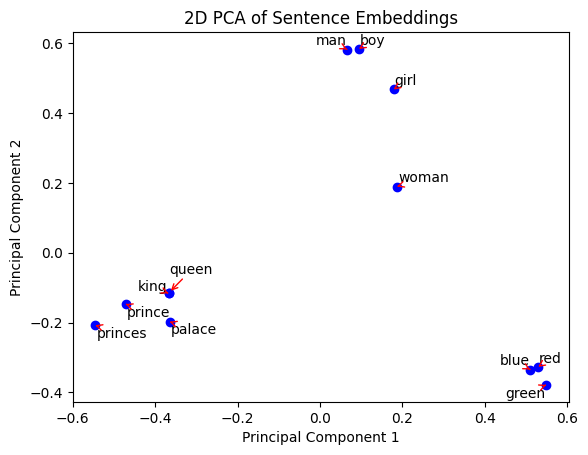

In [40]:
plot(words, embed(words))

# Sentence Embeddings

We can not only embed words but entire sentences or even documents.

In [41]:
documents = [
    "Vector embeddings are mathematical representations of objects, often words or phrases, in a high-dimensional space. By mapping similar objects to proximate points, embeddings capture relationships and semantic meaning. Commonly used in machine learning and natural language processing tasks, methods like Word2Vec, GloVe, and FastText have popularized their application, enabling advancements in text analysis, recommendation systems, and more.",
    "Keyword search refers to the process of locating information in a database, search engine, or other data repository by specifying particular words, phrases, or symbols. In the digital realm, it's foundational to search engines like Google and Bing. The search results are typically ranked based on relevance, which is determined using various algorithms that consider factors like frequency, location, and link structures. Keyword search is integral for navigating the vast expanse of online information, aiding users in retrieving relevant data efficiently.",
    "Sandwiches are a popular type of food consisting of one or more types of food, such as vegetables, sliced meat, or cheese, placed between slices of bread. They can range from simple combinations like peanut butter and jelly to more complex gourmet creations. Originating from England in the 18th century, sandwiches have become a staple in many cultures worldwide, prized for their convenience and versatility. Variations exist based on regional preferences, ingredients, and preparation methods.",
    "Data science is an interdisciplinary field that leverages statistical, computational, and domain-specific expertise to extract insights and knowledge from structured and unstructured data. It encompasses various techniques from statistics, machine learning, data mining, and big data technologies to analyze and interpret complex data. Data science has applications across numerous sectors, including healthcare, finance, marketing, and social sciences, driving decision-making, predictive analytics, and artificial intelligence advancements. Its growing significance in today's data-driven world has led to the rise of specialized tools, methodologies, and educational programs.",
    "Neural networks are a class of machine learning models inspired by the biological neural networks of animal brains. They consist of interconnected layers of nodes, or neurons, which process input data through a series of transformations and connections to produce output. Neural networks are particularly adept at recognizing patterns, making them useful for a wide range of applications such as image and speech recognition, natural language processing, and predictive analytics. The development of deep neural networks, which contain multiple hidden layers, has been central to the field of deep learning and has significantly advanced the capabilities of artificial intelligence systems.",
    "Pasta is a staple food of traditional Italian cuisine, with the first reference dating to 1154 in Sicily. It is typically made from an unleavened dough of durum wheat flour mixed with water or eggs and formed into sheets or various shapes, then cooked by boiling or baking. Pasta is versatile and can be served with a variety of sauces, meats, and vegetables. It is categorized in two basic styles: dried and fresh. Popular around the world, pasta dishes are central to many diets and come in numerous shapes like spaghetti, penne, and ravioli.",
    "Soup is a liquid food, generally served warm or hot (but also cold), that is made by combining ingredients such as meat and vegetables with stock, juice, water, or another liquid. Soups are inherently diverse, ranging from rich, cream-based varieties to brothy and vegetable-laden concoctions. They are often regarded as comfort food and can be served as a main dish or as an appetizer, with regional and cultural variations like the Spanish gazpacho, Japanese miso soup, and Russian borscht.",
    "A casserole is a comprehensive one-dish meal baked in a deep, ovenproof dish with a glass or ceramic base. It typically includes a combination of meats, vegetables, starches like rice or potatoes, and a binding agent like a soup or sauce. Topped with cheese or breadcrumbs for a crispy crust, casseroles are appreciated for their convenience and the ability to meld flavors during the baking process. They are a fixture in many cultures and are particularly beloved as home-cooked comfort foods, often featuring in communal gatherings and family dinners.",
]

In [42]:
pd.DataFrame(
    {
        "Sentence": documents[0:5],
        "Encoding": list(embed(documents[0:5])),
    }
)

,Sentence,Encoding
0,Vector embeddings are mathematical representat...,"[-0.0016682141, -0.06941, -0.026505092, 0.0056..."
1,Keyword search refers to the process of locati...,"[0.019650523, -0.06271497, -0.045780774, -0.00..."
2,Sandwiches are a popular type of food consisti...,"[-0.044322804, -0.023782454, 0.036511306, -0.0..."
3,Data science is an interdisciplinary field tha...,"[-0.017916223, 0.03387719, 0.014666999, 0.0279..."
4,Neural networks are a class of machine learnin...,"[-0.09425652, -0.0771835, 0.0413547, -0.015339..."


Again, semantic clusters appear when visualizing the vectors in a 2D-space.

In [67]:
def plots(*sentences_embeddings_color):
    figure = plt.figure(figsize=(10, 5))
    for (
        sentences,
        embeddings,
        color,
    ) in sentences_embeddings_color:
        plot(sentences, embeddings, color, figure)
    plt.show()

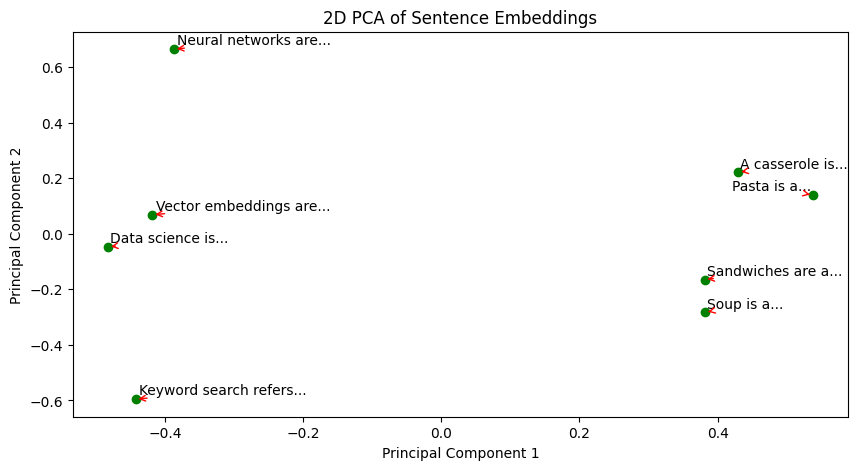

In [68]:
plots((documents, embed(documents), "green"))

The vector representation can also be used for document retrieval by finding the nearest documents. Let's start by defining some search queries.

In [69]:
queries = [
    "information retrieval",
    "machine learning",
    "cooking",
]

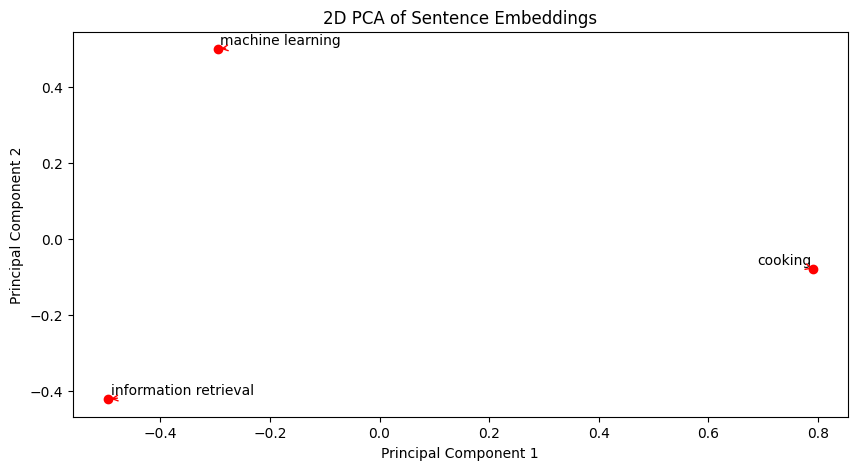

In [70]:
plots((queries, embed(queries), "red"))

Now we visualize the documents and the queries in one space.

Queries and their related documents appear close together.

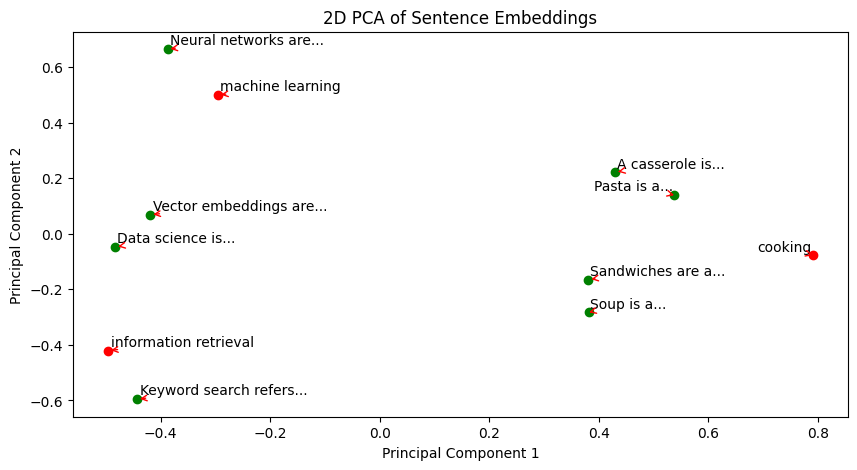

In [71]:
plots(
    (documents, embed(documents), "green"),
    (queries, embed(queries), "red"),
)